In [1]:
# cell 1:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


In [2]:
# cell 2:
if torch.cuda.is_available():
    print("GPU is running and it's name is: ", torch.cuda.get_device_name(0))
else:
    print('CPU is running..')

GPU is running and it's name is:  Tesla T4


In [3]:
# Cell 3: Find and verify dataset
def find_image_dir():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()

if IMAGE_DIR:
    print(f"✓ Found images at: {IMAGE_DIR}")
    # Count total images
    num_images = len([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.jpeg'))])
    print(f"✓ Total images found: {num_images}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

✓ Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
✓ Total images found: 31783


In [4]:
# Cell 4: Feature Extraction (MANDATORY - Run Once)
OUTPUT_FILE = 'flickr30k_features.pkl'

# Dataset class for feature extraction
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# Load ResNet50 and remove final classification layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # 2048-dim features
model = nn.DataParallel(model).to(device)
model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create dataset and dataloader
dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

# Extract features
features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

# Save features
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"✓ Success! {len(features_dict)} images processed")
print(f"✓ Features saved to: {OUTPUT_FILE}")
print(f"✓ Feature shape: {list(features_dict.values())[0].shape}")

Extracting Features: 100%|██████████| 249/249 [01:28<00:00,  2.81it/s]


✓ Success! 31783 images processed
✓ Features saved to: flickr30k_features.pkl
✓ Feature shape: (2048,)


In [5]:
#Cell 5 Load Cached Features
with open('flickr30k_features.pkl', 'rb') as f:
    features = pickle.load(f)

print("Total features:", len(features))


Total features: 31783


In [6]:
#Cell 6 Load captions.txt
import pandas as pd

captions_path = "/kaggle/input/datasets/adityajn105/flickr30k/captions.txt"

captions_df = pd.read_csv(captions_path)

print("Total captions:", len(captions_df))
captions_df.head()


Total captions: 158915


,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [7]:
#Cell 7 — Clean Captions
import re

START_TOKEN = "<start>"
END_TOKEN = "<end>"
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

def clean_caption(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = f"{START_TOKEN} {text} {END_TOKEN}"
    return text

captions_df["clean_caption"] = captions_df["caption"].apply(clean_caption)
captions_df.head()

,image,caption,clean_caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...,<start> two young guys with shaggy hair look a...
1,1000092795.jpg,"Two young , White males are outside near many...",<start> two young white males are outside near...
2,1000092795.jpg,Two men in green shirts are standing in a yard .,<start> two men in green shirts are standing i...
3,1000092795.jpg,A man in a blue shirt standing in a garden .,<start> a man in a blue shirt standing in a ga...
4,1000092795.jpg,Two friends enjoy time spent together .,<start> two friends enjoy time spent together ...


In [8]:
# Cell 8 — Build Vocabulary (WITHOUT rare word removal)
from collections import Counter

all_words = []
for caption in captions_df["clean_caption"]:
    words = caption.split()
    all_words.extend(words)

word_freq = Counter(all_words)

# Get all unique words (NO filtering by frequency)
vocab_words = sorted(word_freq.keys())

# Add special tokens FIRST
special_tokens = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN]

# Remove special tokens from vocab_words if they already exist
vocab_words = [w for w in vocab_words if w not in special_tokens]

# Combine: special tokens first, then sorted words
vocab = special_tokens + vocab_words

# Create mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)

print("Vocabulary Size:", vocab_size)
print(f"PAD index: {word2idx[PAD_TOKEN]}")
print(f"UNK index: {word2idx[UNK_TOKEN]}")
print(f"START index: {word2idx[START_TOKEN]}")
print(f"END index: {word2idx[END_TOKEN]}")

Vocabulary Size: 19774
PAD index: 0
UNK index: 1
START index: 2
END index: 3


In [9]:
# Cell 9 — Convert Captions to Numerical Sequences (Corrected)

import torch

MAX_LEN = 30  # Maximum caption length

def caption_to_seq(caption, word2idx, unk_token="<unk>"):
    seq = [word2idx.get(word, word2idx[unk_token]) for word in caption.split()]
    
    # Truncate if longer than MAX_LEN
    if len(seq) > MAX_LEN:
        seq = seq[:MAX_LEN]
        
    return seq

# Apply conversion (NO global padding here)
captions_df["seq"] = captions_df["clean_caption"].apply(
    lambda x: caption_to_seq(x, word2idx, UNK_TOKEN)
)

pad_idx = word2idx[PAD_TOKEN]

print("Example cleaned caption:", captions_df["clean_caption"].iloc[0])
print("Numerical sequence:", captions_df["seq"].iloc[0])
print("Sequence length:", len(captions_df["seq"].iloc[0]))


Example cleaned caption: <start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>
Numerical sequence: [2, 18312, 19711, 7673, 19462, 15124, 7702, 9975, 827, 17545, 7821, 19259, 7842, 11745, 8634, 17537, 19644, 3]
Sequence length: 18


In [10]:
# DEBUG: Check for invalid indices
max_idx_in_seqs = max(max(seq) for seq in captions_df["seq"])
min_idx_in_seqs = min(min(seq) for seq in captions_df["seq"])

print(f"Vocab size: {vocab_size}")
print(f"Max index in sequences: {max_idx_in_seqs}")
print(f"Min index in sequences: {min_idx_in_seqs}")

if max_idx_in_seqs >= vocab_size:
    print("❌ ERROR: Some sequences have indices >= vocab_size!")
else:
    print("✅ All sequence indices are valid")

Vocab size: 19774
Max index in sequences: 19773
Min index in sequences: 2
✅ All sequence indices are valid


In [11]:
# Cell 10 — Train / Validation Split
from sklearn.model_selection import train_test_split

# Get unique images from dataframe
all_images = captions_df["image"].unique()
print("Total unique images:", len(all_images))

# Split 80/20
train_images, val_images = train_test_split(
    all_images,
    test_size=0.2,
    random_state=42
)

print("Training images:", len(train_images))
print("Validation images:", len(val_images))

Total unique images: 31783
Training images: 25426
Validation images: 6357


In [12]:
# Cell 11: Create CaptionDataset class (CORRECTED)
from torch.utils.data import Dataset
import torch

class CaptionDataset(Dataset):
    def __init__(self, image_list, captions_df, features_dict, word2idx):
        """
        image_list: list of image names (train_images or val_images)
        captions_df: DataFrame with columns ['image', 'seq']
        features_dict: dict {image_name: 2048-dim numpy array}
        word2idx: vocabulary mapping
        """
        self.samples = []
        
        # Create image set for fast lookup
        image_set = set(image_list)
        
        # Filter entire dataframe ONCE
        filtered_df = captions_df[captions_df['image'].isin(image_set)]
        
        # Process each row
        for _, row in filtered_df.iterrows():
            img_name = row['image']
            seq = row['seq']
            
            # Get image feature (convert numpy array to tensor)
            img_feature = torch.from_numpy(features_dict[img_name]).float()
            
            # Teacher forcing
            input_seq = torch.tensor(seq[:-1], dtype=torch.long)
            target_seq = torch.tensor(seq[1:], dtype=torch.long)
            
            self.samples.append((img_feature, input_seq, target_seq))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

# Create datasets
train_dataset = CaptionDataset(train_images, captions_df, features_dict, word2idx)
val_dataset = CaptionDataset(val_images, captions_df, features_dict, word2idx)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Train dataset size: 127130
Validation dataset size: 31785


In [13]:
# Cell 12: Create DataLoader with padding
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64
pad_idx = word2idx[PAD_TOKEN]

def collate_fn(batch):
    """
    Custom collate function to pad sequences in a batch
    batch: list of (img_feature, input_seq, target_seq)
    """
    # Separate features and sequences
    features = torch.stack([item[0] for item in batch])  # (batch_size, 2048)
    input_seqs = [item[1] for item in batch]
    target_seqs = [item[2] for item in batch]
    
    # Pad sequences to same length
    input_seqs_padded = pad_sequence(input_seqs, batch_first=True, padding_value=pad_idx)
    target_seqs_padded = pad_sequence(target_seqs, batch_first=True, padding_value=pad_idx)
    
    return features, input_seqs_padded, target_seqs_padded

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))

# Test a batch
for features, inputs, targets in train_loader:
    print("Feature batch shape:", features.shape)
    print("Input batch shape:", inputs.shape)
    print("Target batch shape:", targets.shape)
    break

Number of training batches: 1987
Number of validation batches: 497
Feature batch shape: torch.Size([64, 2048])
Input batch shape: torch.Size([64, 29])
Target batch shape: torch.Size([64, 29])


In [14]:
#Cell 13: Encoder class (Linear 2048 → hidden_size)

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, feature_dim=2048, hidden_dim=512):
        super(Encoder, self).__init__()
        
        self.fc = nn.Linear(feature_dim, hidden_dim)
        self.relu = nn.ReLU()
    
    def forward(self, features):
        """
        features: (batch_size, 2048)
        """
        out = self.fc(features)     # (batch_size, 512)
        out = self.relu(out)
        return out


In [15]:
# Cell 14: Decoder class (Embedding + LSTM + Linear)
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, dropout=0.5):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, captions, hidden):
        embeddings = self.dropout(self.embedding(captions))
        outputs, hidden = self.lstm(embeddings, hidden)
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        return outputs, hidden

In [16]:
#  Cell 15 — Combine Encoder + Decoder 

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, feature_dim=2048, embed_dim=256, hidden_dim=512):
        super(ImageCaptioningModel, self).__init__()
        
        self.encoder = Encoder(feature_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, embed_dim, hidden_dim)
    
    def forward(self, features, captions):
        """
        features: (batch_size, 2048)
        captions: (batch_size, seq_length)
        """
        
        # Encode image
        encoded_features = self.encoder(features)   # (batch, hidden_dim)
        
        # Initialize LSTM hidden state
        h0 = encoded_features.unsqueeze(0)          # (1, batch, hidden_dim)
        c0 = torch.zeros_like(h0)                   # initialize cell state
        
        # Decode
        outputs, _ = self.decoder(captions, (h0, c0))
        
        return outputs


In [17]:
# Cell 15B: Initialize model
HIDDEN_DIM = 512
EMBED_DIM = 256

model = ImageCaptioningModel(
    vocab_size=vocab_size,
    feature_dim=2048,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM
).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 17,832,254 parameters


In [18]:
# Cell 16: Loss + Optimizer (CrossEntropyLoss with ignore_index

import torch.optim as optim

# Ignore padding tokens while computing loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# Adam optimizer with lower learning rate + L2 regularization

optimizer = optim.Adam(model.parameters(), lr=2e-4  , weight_decay=1e-5)

print("Loss and optimizer initialized (updated).")


Loss and optimizer initialized (updated).


In [19]:
# Cell 17: Training loop (epochs, forward, backward, validation)

from tqdm import tqdm
import torch

EPOCHS = 30  # Instead of 20
patience = 4  # Instead of 3

train_losses = []
val_losses = []

best_val_loss = float('inf')
counter = 0

for epoch in range(EPOCHS):
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # ---- TRAINING ----
    model.train()
    total_train_loss = 0
    
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for features, captions_input, captions_target in train_bar:
        
        features = features.to(device)
        captions_input = captions_input.to(device)
        captions_target = captions_target.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features, captions_input)
        
        outputs = outputs.reshape(-1, vocab_size)
        captions_target = captions_target.reshape(-1)
        
        loss = criterion(outputs, captions_target)
        
        loss.backward()
        
        # ✅ Added Gradient Clipping (VERY IMPORTANT for LSTM)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        train_bar.set_postfix(loss=loss.item())
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    
    # ---- VALIDATION ----
    model.eval()
    total_val_loss = 0
    
    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for features, captions_input, captions_target in val_bar:
            
            features = features.to(device)
            captions_input = captions_input.to(device)
            captions_target = captions_target.to(device)
            
            outputs = model(features, captions_input)
            
            outputs = outputs.reshape(-1, vocab_size)
            captions_target = captions_target.reshape(-1)
            
            loss = criterion(outputs, captions_target)
            
            total_val_loss += loss.item()
            
            val_bar.set_postfix(loss=loss.item())
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    
    # ---- EARLY STOPPING ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation improved. Model saved.")
    else:
        counter += 1
        print(f"No improvement. Patience counter: {counter}/{patience}")
        
        if counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/30


Train Loss: 4.6702 | Val Loss: 4.0263
Validation improved. Model saved.

Epoch 2/30


Train Loss: 3.9537 | Val Loss: 3.6814
Validation improved. Model saved.

Epoch 3/30


Train Loss: 3.6936 | Val Loss: 3.5001
Validation improved. Model saved.

Epoch 4/30


Train Loss: 3.5347 | Val Loss: 3.3913
Validation improved. Model saved.

Epoch 5/30


Train Loss: 3.4234 | Val Loss: 3.3209
Validation improved. Model saved.

Epoch 6/30


Train Loss: 3.3367 | Val Loss: 3.2636
Validation improved. Model saved.

Epoch 7/30


Train Loss: 3.2672 | Val Loss: 3.2253
Validation improved. Model saved.

Epoch 8/30


Train Loss: 3.2074 | Val Loss: 3.1917
Validation improved. Model saved.

Epoch 9/30


Train Loss: 3.1565 | Val Loss: 3.1690
Validation improved. Model saved.

Epoch 10/30


Train Loss: 3.1103 | Val Loss: 3.1450
Validation improved. Model saved.

Epoch 11/30


Train Loss: 3.0698 | Val Loss: 3.1324
Validation improved. Model saved.

Epoch 12/30


Train Loss: 3.0326 | Val Loss: 3.1237
Validation improved. Model saved.

Epoch 13/30


Train Loss: 2.9981 | Val Loss: 3.1101
Validation improved. Model saved.

Epoch 14/30


Train Loss: 2.9668 | Val Loss: 3.1047
Validation improved. Model saved.

Epoch 15/30


Train Loss: 2.9375 | Val Loss: 3.0947
Validation improved. Model saved.

Epoch 16/30


Train Loss: 2.9105 | Val Loss: 3.0921
Validation improved. Model saved.

Epoch 17/30


Train Loss: 2.8854 | Val Loss: 3.0882
Validation improved. Model saved.

Epoch 18/30


Train Loss: 2.8622 | Val Loss: 3.0866
Validation improved. Model saved.

Epoch 19/30


Train Loss: 2.8410 | Val Loss: 3.0838
Validation improved. Model saved.

Epoch 20/30


Train Loss: 2.8197 | Val Loss: 3.0813
Validation improved. Model saved.

Epoch 21/30


Train Loss: 2.8013 | Val Loss: 3.0808
Validation improved. Model saved.

Epoch 22/30


Train Loss: 2.7831 | Val Loss: 3.0823
No improvement. Patience counter: 1/4

Epoch 23/30


Train Loss: 2.7662 | Val Loss: 3.0805
Validation improved. Model saved.

Epoch 24/30


Train Loss: 2.7498 | Val Loss: 3.0802
Validation improved. Model saved.

Epoch 25/30


Train Loss: 2.7343 | Val Loss: 3.0855
No improvement. Patience counter: 1/4

Epoch 26/30


Train Loss: 2.7194 | Val Loss: 3.0846
No improvement. Patience counter: 2/4

Epoch 27/30


Train Loss: 2.7064 | Val Loss: 3.0836
No improvement. Patience counter: 3/4

Epoch 28/30


Train Loss: 2.6927 | Val Loss: 3.0878
No improvement. Patience counter: 4/4
Early stopping triggered.


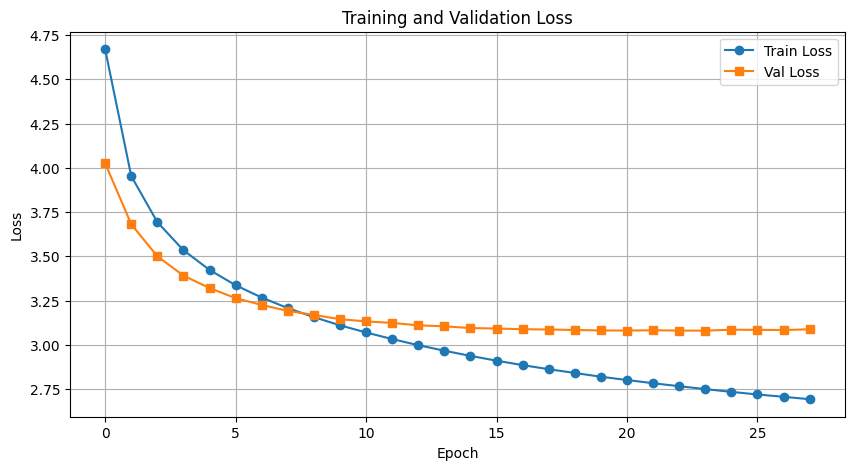

In [20]:
# Cell 18: Plot loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Cell 19: Greedy search function
def generate_caption_greedy(model, image_feature, word2idx, idx2word, max_len=30):
    model.eval()
    
    # Encode image
    with torch.no_grad():
        image_feature = image_feature.unsqueeze(0).to(device)  # (1, 2048)
        encoded = model.encoder(image_feature)  # (1, 512)
        
        # Initialize hidden state
        h0 = encoded.unsqueeze(0)  # (1, 1, 512)
        c0 = torch.zeros_like(h0)
        hidden = (h0, c0)
        
        # Start with <start> token
        input_word = torch.tensor([[word2idx[START_TOKEN]]]).to(device)
        
        caption = []
        
        for _ in range(max_len):
            # Forward through decoder
            output, hidden = model.decoder(input_word, hidden)
            
            # Get predicted word
            predicted_idx = output.argmax(dim=2).item()
            
            # Stop if <end> token
            if predicted_idx == word2idx[END_TOKEN]:
                break
            
            word = idx2word[predicted_idx]
            caption.append(word)
            
            # Next input
            input_word = torch.tensor([[predicted_idx]]).to(device)
    
    return ' '.join(caption)

In [26]:
# Cell 20: Beam search function (CORRECTED)
def generate_caption_beam(model, image_feature, word2idx, idx2word, beam_width=3, max_len=30):
    model.eval()
    
    with torch.no_grad():
        image_feature = image_feature.unsqueeze(0).to(device)
        encoded = model.encoder(image_feature)
        
        h0 = encoded.unsqueeze(0)
        c0 = torch.zeros_like(h0)
        
        # Initialize beam: [(sequence, score, hidden, finished)]
        beams = [([word2idx[START_TOKEN]], 0.0, (h0, c0), False)]
        completed = []
        
        for step in range(max_len):
            candidates = []
            
            for seq, score, hidden, finished in beams:
                # If sequence already ended, just keep it
                if finished or seq[-1] == word2idx[END_TOKEN]:
                    completed.append((seq, score, hidden, True))
                    continue
                
                input_word = torch.tensor([[seq[-1]]]).to(device)
                output, new_hidden = model.decoder(input_word, hidden)
                
                # Get top k predictions
                log_probs = torch.log_softmax(output[0, 0], dim=0)
                top_probs, top_indices = log_probs.topk(beam_width)
                
                for prob, idx in zip(top_probs, top_indices):
                    new_seq = seq + [idx.item()]
                    new_score = score + prob.item()
                    is_finished = (idx.item() == word2idx[END_TOKEN])
                    candidates.append((new_seq, new_score, new_hidden, is_finished))
            
            # Combine completed and candidates
            all_beams = completed + candidates
            
            # Sort by normalized score (divide by length to avoid short sequence bias)
            all_beams = sorted(all_beams, key=lambda x: x[1] / len(x[0]), reverse=True)
            
            # Split into completed and active beams
            completed = [b for b in all_beams if b[3]][:beam_width]
            beams = [b for b in all_beams if not b[3]][:beam_width]
            
            # Stop if we have enough completed sequences
            if len(completed) >= beam_width:
                break
            
            # Stop if no active beams
            if len(beams) == 0:
                break
        
        # Get best sequence from completed (or best active if none completed)
        if len(completed) > 0:
            best_seq = completed[0][0]
        else:
            best_seq = beams[0][0]
        
        caption = [idx2word[idx] for idx in best_seq if idx not in [word2idx[START_TOKEN], word2idx[END_TOKEN]]]
    
    return ' '.join(caption)

In [27]:
# Cell 21: BLEU-4 score (WITH FIXED SEED)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random

# Fix random seed for reproducibility
random.seed(42)

# Sample validation images (will be same 100 images every time now)
sample_images = random.sample(list(val_images), min(100, len(val_images)))

bleu_scores = []
smoothing = SmoothingFunction().method1

for img_name in sample_images:
    img_captions = captions_df[captions_df['image'] == img_name]['clean_caption'].tolist()
    references = [caption.replace(START_TOKEN, '').replace(END_TOKEN, '').strip().split() for caption in img_captions]
    
    img_feature = torch.from_numpy(features_dict[img_name]).float()
    generated = generate_caption_greedy(model, img_feature, word2idx, idx2word)
    hypothesis = generated.split()
    
    score = sentence_bleu(references, hypothesis, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    bleu_scores.append(score)

avg_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU-4 Score: {avg_bleu:.4f}")

Average BLEU-4 Score: 0.1224


In [28]:
# Cell 22: Precision, Recall, F1 (token-level)
def calculate_metrics(reference, hypothesis):
    ref_tokens = set(reference.split())
    hyp_tokens = set(hypothesis.split())
    
    if len(hyp_tokens) == 0:
        return 0, 0, 0
    
    true_positive = len(ref_tokens & hyp_tokens)
    precision = true_positive / len(hyp_tokens) if len(hyp_tokens) > 0 else 0
    recall = true_positive / len(ref_tokens) if len(ref_tokens) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

precisions, recalls, f1s = [], [], []

for img_name in sample_images:
    # Ground truth (first caption)
    reference = captions_df[captions_df['image'] == img_name]['clean_caption'].iloc[0]
    reference = reference.replace(START_TOKEN, '').replace(END_TOKEN, '').strip()
    
    # Generated caption
    img_feature = torch.from_numpy(features_dict[img_name]).float()
    hypothesis = generate_caption_greedy(model, img_feature, word2idx, idx2word)
    
    p, r, f = calculate_metrics(reference, hypothesis)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")
print(f"F1-Score: {sum(f1s)/len(f1s):.4f}")

Precision: 0.3711
Recall: 0.2402
F1-Score: 0.2820


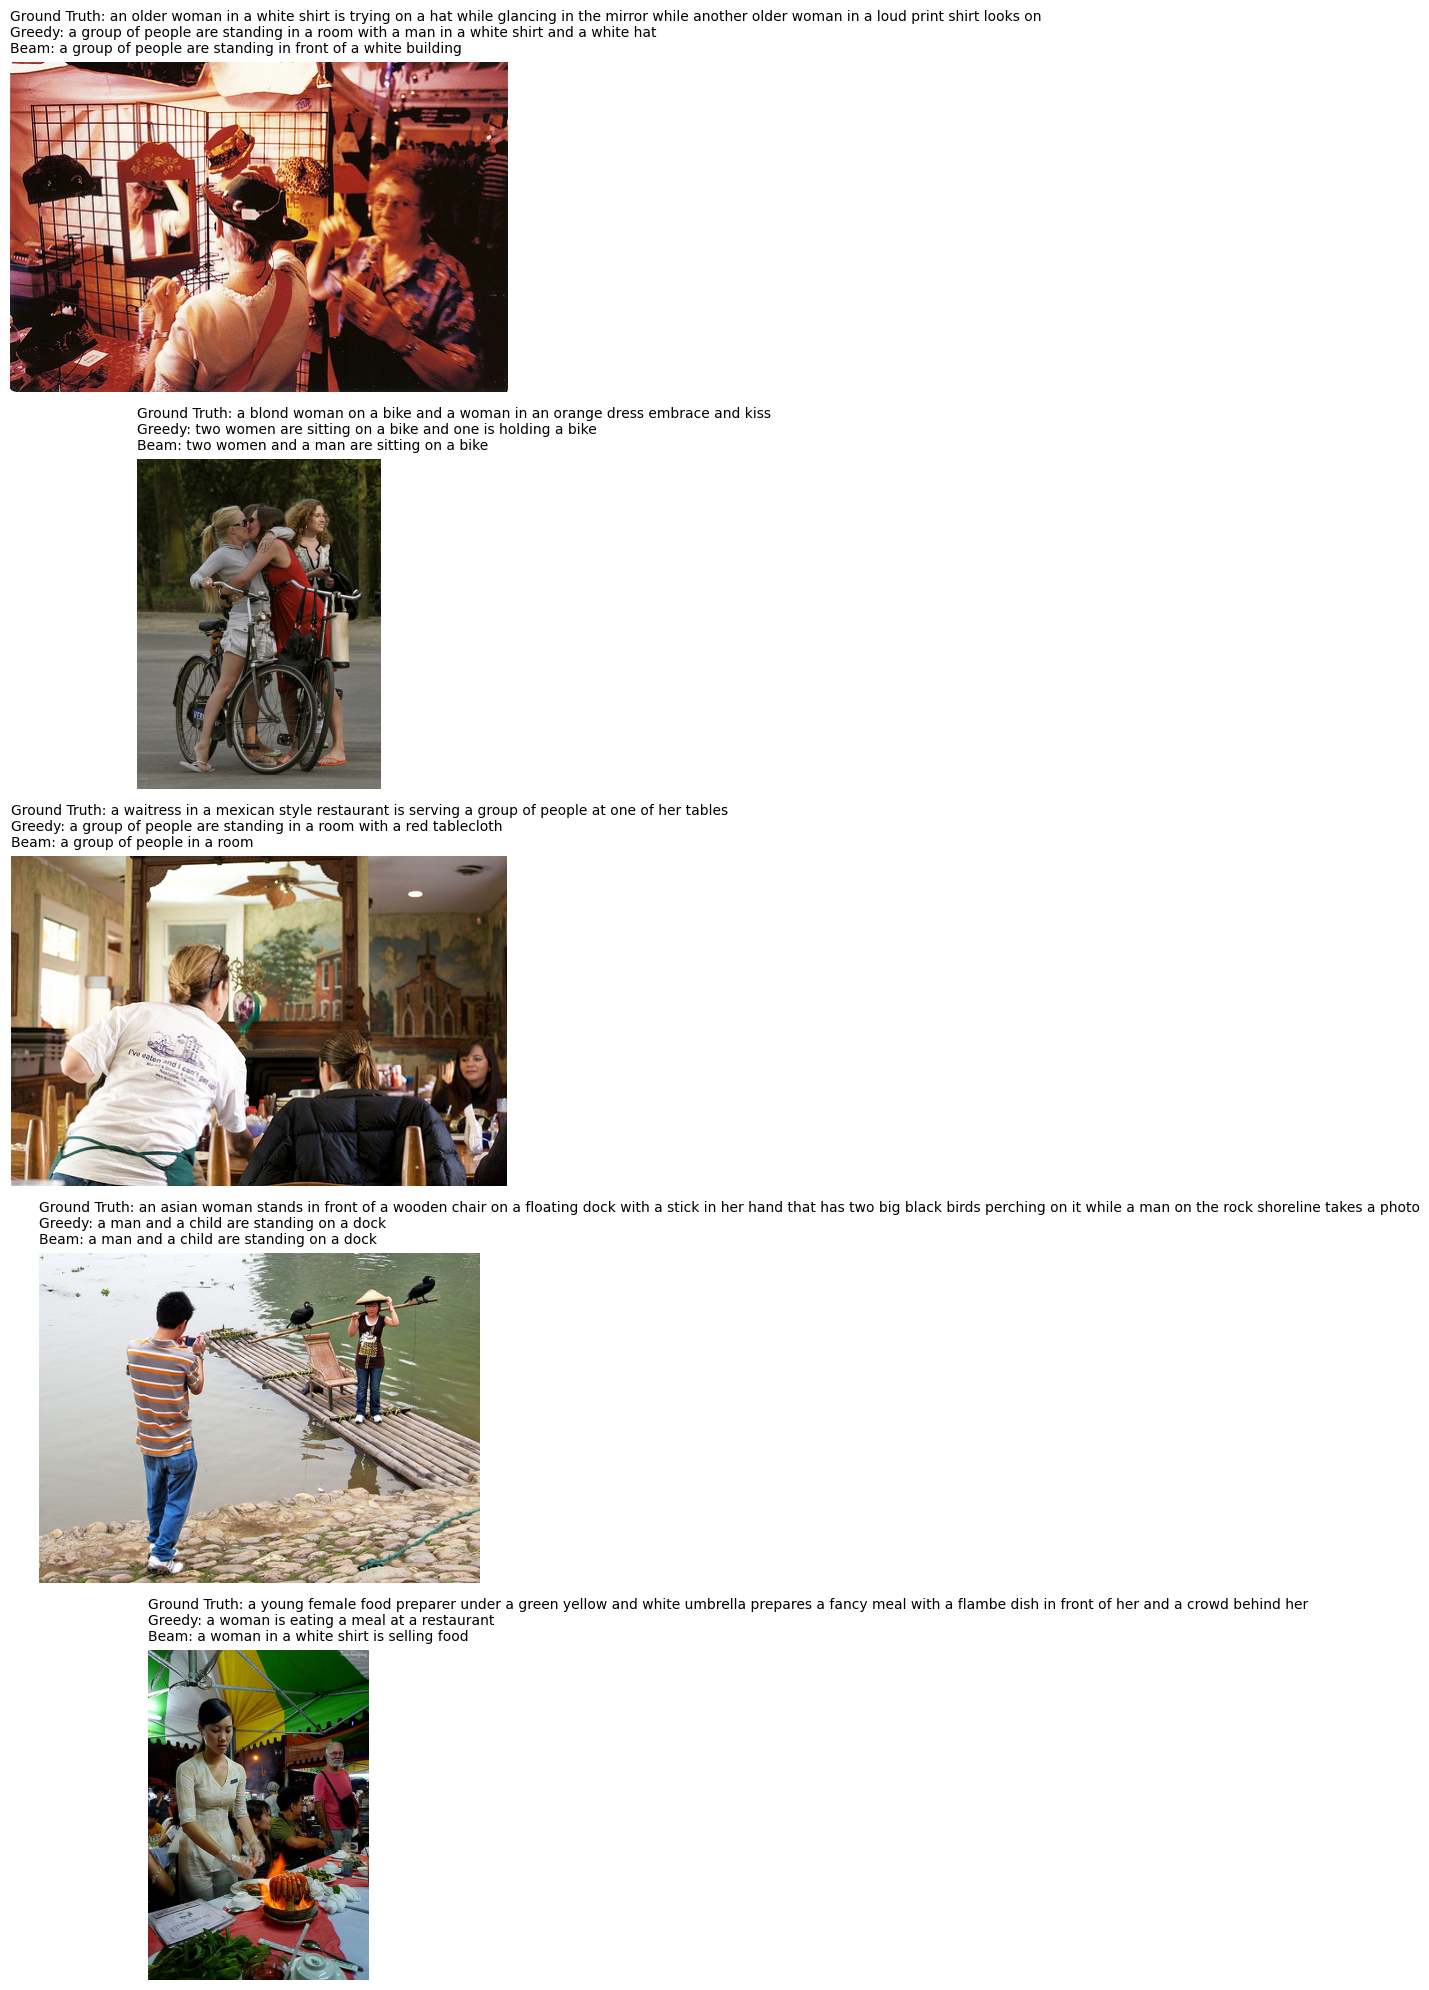

In [29]:
# Cell 23: Display 5 random test images with captions
import matplotlib.pyplot as plt
from PIL import Image

# Select 5 random validation images (convert to list)
test_images = random.sample(list(val_images), 5)

fig, axes = plt.subplots(5, 1, figsize=(12, 20))

for idx, img_name in enumerate(test_images):
    # Load image
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path)
    
    # Ground truth
    ground_truth = captions_df[captions_df['image'] == img_name]['clean_caption'].iloc[0]
    ground_truth = ground_truth.replace(START_TOKEN, '').replace(END_TOKEN, '').strip()
    
    # Generated captions
    img_feature = torch.from_numpy(features_dict[img_name]).float()
    greedy_caption = generate_caption_greedy(model, img_feature, word2idx, idx2word)
    beam_caption = generate_caption_beam(model, img_feature, word2idx, idx2word, beam_width=3)
    
    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Ground Truth: {ground_truth}\n"
                        f"Greedy: {greedy_caption}\n"
                        f"Beam: {beam_caption}", 
                        fontsize=10, loc='left')

plt.tight_layout()
plt.show()

In [39]:
# Cell 24: Save model weights
torch.save(model.state_dict(), "final_caption_model.pth")
print("✓ Model saved as 'final_caption_model.pth'")
print("✓ Best model already saved as 'best_model.pth'")

✓ Model saved as 'final_caption_model.pth'
✓ Best model already saved as 'best_model.pth'


In [44]:
# Cell: Save vocabularies for Gradio app
import pickle

# Save word2idx
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

# Save idx2word
with open('idx2word.pkl', 'wb') as f:
    pickle.dump(idx2word, f)

print("✓ word2idx.pkl saved")
print("✓ idx2word.pkl saved")
print("\nDownload these files along with best_model.pth for deployment")

✓ word2idx.pkl saved
✓ idx2word.pkl saved

Download these files along with best_model.pth for deployment


In [32]:
# Cell 25A: Upload image widget
from IPython.display import display
import ipywidgets as widgets
import io

uploader = widgets.FileUpload(accept='image/*', multiple=False)
print("Upload an image using the button below:")
display(uploader)

Upload an image using the button below:


FileUpload(value=(), accept='image/*', description='Upload')

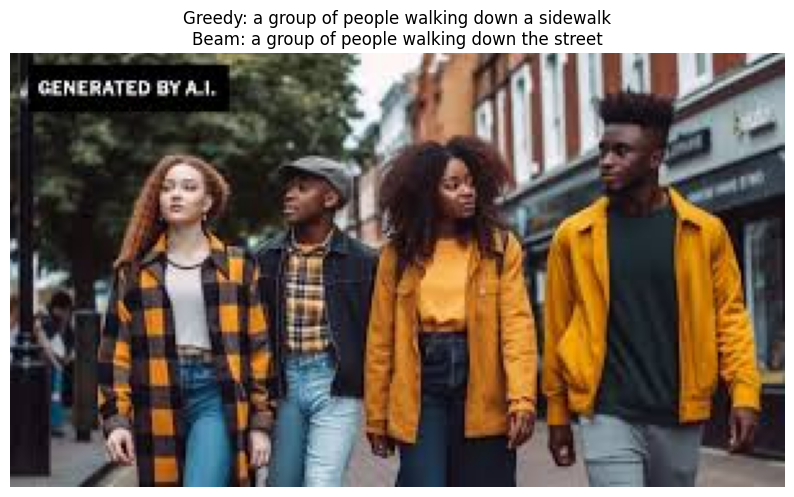

In [51]:
# Cell 25B: Process uploaded image
from PIL import Image
import matplotlib.pyplot as plt

# Check if file uploaded
if len(uploader.value) == 0:
    print("❌ No image uploaded! Please upload an image in the cell above first.")
else:
    # Get uploaded image
    img = Image.open(io.BytesIO(uploader.value[0]['content']))
    
    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    # Extract features
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    resnet = nn.Sequential(*list(resnet.children())[:-1])
    resnet = resnet.to(device)
    resnet.eval()
    
    with torch.no_grad():
        img_tensor = transform(img).unsqueeze(0).to(device)
        feature = resnet(img_tensor).view(-1).cpu()
    
    # Generate captions
    greedy_caption = generate_caption_greedy(model, feature, word2idx, idx2word)
    beam_caption = generate_caption_beam(model, feature, word2idx, idx2word, beam_width=3)
    
    # Display
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Greedy: {greedy_caption}\nBeam: {beam_caption}", fontsize=12)
    plt.show()